# Generalize transects
### Generalize transects to calculate transport in density space through a region that is defined by either (1) transects identified via algorithm or (2) geojson mask

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps
import gsw
import warnings 
import glob
from xgcm import Grid

In [36]:
# open mesh and filepaths
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
# dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc', decode_timedelta=True)

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
# base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')


In [37]:
# open datasets with just the variables that we want

months = ['01','02','03','04','05','06','07','08','09','10','11','12']
ds_list = []

prefix = '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStats'

year = 3 # int
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(0,12):
        month = months[i]
        file = prefix + f'Monthly.{str(year).zfill(4)}-{month}-01.nc'
        file_glob = glob.glob(file)
        ds = xr.open_dataset(bmm_filepath + file)[['xtime_startMonthly','timeMonthly_avg_normalVelocity','timeMonthly_avg_potentialDensity','timeMonthly_avg_layerThickness',
                                                   'nCells','nEdges','nVertLevels','nVertLevelsP1']]
        ds_xtime_startMonthly = ds.swap_dims({'Time':'xtime_startMonthly'})
        ds_list.append(ds_xtime_startMonthly)

dss = xr.concat(ds_list,dim='xtime_startMonthly')

In [38]:
ds = mps.add_grid_info_coords(mesh,dss)
ds['lonCell'] = ds.lonCell 
ds['lonEdge'] = ds.lonEdge 
ds['lonVertex'] = ds.lonVertex 

In [139]:
mesh.lonVertex.max()

<xarray.DataArray 'lonVertex' ()> Size: 8B
array(6.28317757)

In [138]:
# set up descriptor for plotting 

mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

# Transport for a region defined by a transect

## Create mask for region from transect

In [54]:
def calculate_transects_multiple_pts(segment_lons,segment_lats,ds):
    """
    Calculate transects given the longitude and latitude vertices in a polygon.
    Calls calculate_transects

    Parameters
    ----------
    segment_lons: numpy.ndarray
        Longitude, in degrees, of consecutive vertices making up a polygon

    segment_lats: numpy.ndarray
        Latitude, in degrees, of consecutive vertices making up a polygon

    ds: xarray.core.dataset.Dataset
        Contains information about ocean model grid coordinates.

    Returns
    -------
    all_xr_transect_vertices: numpy.ndarray
        xr indices of vertices in transect, sorted in consecutive order

    all_xr_transect_edges: numpy.ndarray
        xr indices of edges in transect, sorted in consecutive order
    """
    all_xr_transect_vertices = np.array([])
    all_xr_transect_edges = np.array([])

    for i in range(0,len(segment_lons)-1):
        
        # set start and end target points based on segment lons and lats
        target_start_lat = segment_lats[i]
        target_start_lon = segment_lons[i]

        target_end_lat = segment_lats[i+1]
        target_end_lon = segment_lons[i+1]
        
        xr_transect_edges_segment, xr_next_vertices = mps.calculate_transects(target_start_lat, target_start_lon, target_end_lat, target_end_lon, ds)

        # update all_xr_transect_ arrays
        all_xr_transect_vertices = np.concatenate((all_xr_transect_vertices, xr_next_vertices))
        all_xr_transect_edges = np.concatenate((all_xr_transect_edges, xr_transect_edges_segment))

    return all_xr_transect_edges, all_xr_transect_vertices

In [55]:
lats = np.array([-50,-30,-30, -50])
lons = np.array([10, 10, 350, 350])
test_edges, test_vertices = calculate_transects_multiple_pts(lons, lats, ds)

In [57]:
test_vertices

array([ 52236., 262956., 262956., 422675., 422675.,  44486.])

In [68]:
test_edges, test_verts = mps.calculate_transects_multiple_pts(lons,lats,ds)

In [84]:
test_verts_lats, test_verts_lons, dsMasks = mps.transect_from_alg_create_nc(test_verts, 
                                                                            ds, 
                                                                            path,
                                                                            filename, 
                                                                            geojson_file_name,
                                                                            tags, 
                                                                            author)

entire_SO_test40_transect_from_alg.geojson exists!
Opening entire_SO_test40_transect_from_alg.nc as dsMasks


In [182]:
with open('./entire_SO_test40_transect_from_alg.geojson') as f:
    gj = geojson.load(f)

gj_lons = np.array(gj['features'][0]['geometry']['coordinates'][0])[:,0]
gj_lats = np.array(gj['features'][0]['geometry']['coordinates'][0])[:,1]

In [190]:
ds.lonVertex.min()

<xarray.DataArray 'lonVertex' ()> Size: 8B
array(3.67336638e-06)
Coordinates:
    simulationStartTime  |S64 64B b'0001-01-01_00:00:00'

In [177]:
gj['features'][0]['geometry']['coordinates'][0]

[[10.135969, -50.241193],
 [9.82981, -30.056125],
 [9.82981, -30.056125],
 [350.020674, -30.116379],
 [350.020674, -30.116379],
 [350.08132, -49.990919],
 [350.08132, -49.990919]]

In [187]:
mask = dsMasks
cellmask = mask.regionCellMasks.isel(nRegions=0).astype(bool)

# if nRegions = 0, bool = False
# if nRegions = 1, bool = True
dsMasks

<xarray.Dataset> Size: 947kB
Dimensions:          (nCells: 236853, nRegions: 1)
Dimensions without coordinates: nCells, nRegions
Data variables:
    regionCellMasks  (nCells, nRegions) int32 947kB 0 0 0 0 0 1 ... 0 0 0 0 0 0
    regionNames      (nRegions) |S64 64B ...

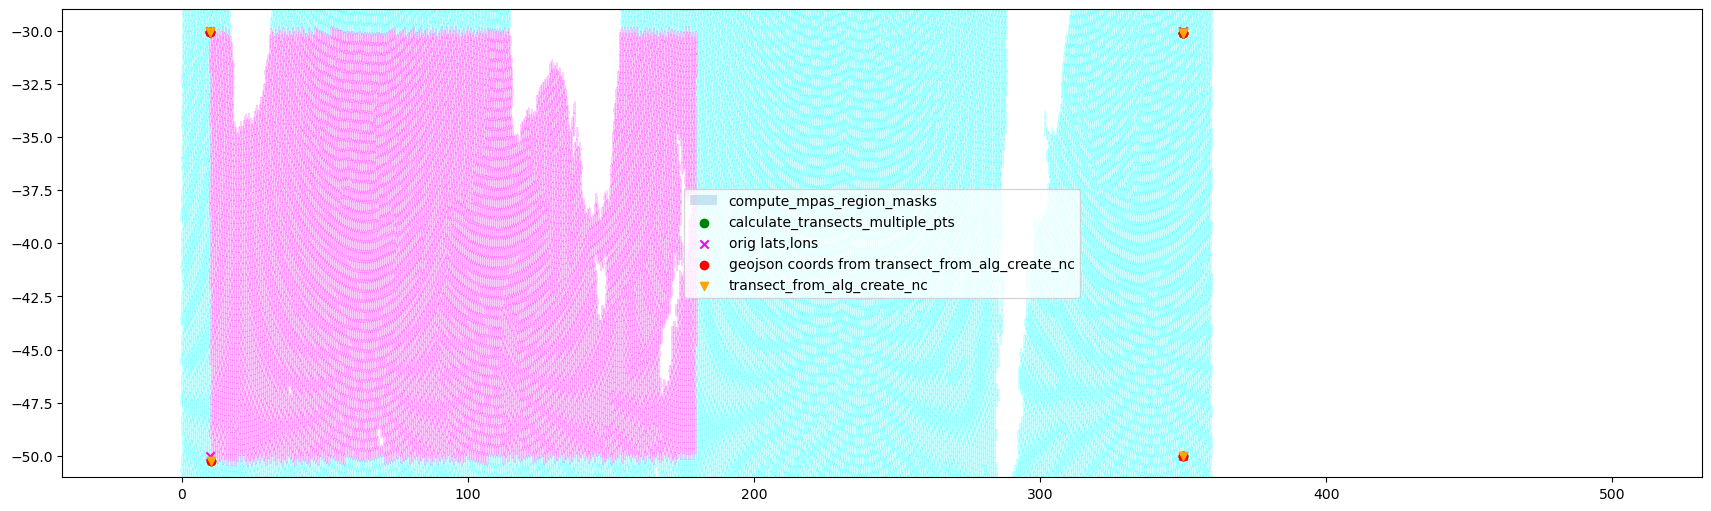

In [185]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(17,5))
# plot using vertex lats and lons (removed vertices on cells not in the mask)
vertex_lons = ds.lonVertex.isel(nVertices = np.int32(test_vertices)) * 180 / np.pi # convert from radians to degrees 
vertex_lats = ds.latVertex.isel(nVertices = np.int32(test_vertices)) * 180 / np.pi # convert from radians to degrees



c = mosaic.polypcolor(ax,descriptor,
                  cellmask.astype(int),cmap='cool',alpha = 0.2,
                  antialiaseds=False, label = 'compute_mpas_region_masks')

ax.scatter(vertex_lons,vertex_lats,c='green',label='calculate_transects_multiple_pts')
ax.scatter(lons,lats,marker='x',c='magenta',label='orig lats,lons')
ax.scatter(gj_lons, gj_lats,c='red',label='geojson coords from transect_from_alg_create_nc')
ax.scatter(test_verts_lons, test_verts_lats,marker='v',c='orange',label='transect_from_alg_create_nc')

ax.set_ylim(-51,-29)
ax.legend(loc='center')

In [94]:
dsMasks

<xarray.Dataset> Size: 947kB
Dimensions:          (nCells: 236853, nRegions: 1)
Dimensions without coordinates: nCells, nRegions
Data variables:
    regionCellMasks  (nCells, nRegions) int32 947kB ...
    regionNames      (nRegions) |S64 64B ...

In [70]:
test_verts_lats, test_verts_lons, dsMasks = transect_from_alg_create_nc(test_verts, 
                                                                            ds, 
                                                                            path,
                                                                            filename, 
                                                                            geojson_file_name,
                                                                            tags, 
                                                                            author)

entire_SO_test40_transect_from_alg.geojson exists!
Opening entire_SO_test40_transect_from_alg.nc as dsMasks


In [ ]:
# plot this masked region
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

# LS the target start and end points when creating the algorithm
ax.plot(lons, lats, color='blue',label='1. target_start and end')

# plot the cellmask created from the cell centers in the mask (id'd with MPAS-tools)
# we don't need to worry about the mps.find_and_sort_transect_edges_and_vertices function because 
# the cell centers will always be inside the mask
# create cellmasks (which cells centers are included in the masked region)

cellmask = mask.regionCellMasks.isel(nRegions=0).astype(bool)
c = mosaic.polypcolor(ax,descriptor,
                  cellmask.astype(int),cmap='cool',alpha = 0.5,
                  antialiaseds=False, label = '2. Cell Centers')

fig.colorbar(c, extend='both')

# LS (lats and lons of vertices from transect)
# ax.scatter(test_verts_lons + 360,test_verts_lats, s=60,marker='^',color='orange',label='3. test_verts')


# plot using vertex lats and lons (removed vertices on cells not in the mask)
vertex_lons = ds.lonVertex.isel(nVertices = alg_vertices) * 180 / np.pi
vertex_lats = ds.latVertex.isel(nVertices = alg_vertices) * 180 / np.pi

# plot the vertices after removing where there are duplicates. 
# the colorbar shows the index of the lons and lats for each vertex 
# (since it is a gradient --> the vertex lats and lons are in order)
ax.scatter(vertex_lons,vertex_lats,c=np.arange(0,len(vertex_lons)),label='3. alg_verts')

# ax.set_ylim(-70,-25)
# ax.set_xlim(160,200)

ax.set_title('Vertex locations determined by each step in creating transects from algorithm')
ax.legend(loc='lower left')

#fig.suptitle('Grid variables from mask made from transect algorithm + MPAS-Tools')

In [43]:
test_verts_lats, test_verts_lons, dsMasks = transect_from_alg_create_nc(test_verts,ds,path,filename,geojson_file_name,tags,author)


entire_SO_test40_transect_from_alg.geojson exists!
Opening entire_SO_test40_transect_from_alg.nc as dsMasks


In [49]:
test_verts_lats.max()

<xarray.DataArray 'latVertex' ()> Size: 8B
array(-30.05612451)
Coordinates:
    simulationStartTime  |S64 64B ...

In [ ]:
breaaak

In [53]:
path = './'
filename = 'entire_SO_test40'
geojson_file_name = 'Southern Ocean region encomapssing Drake passage from transect algorithm'
tags = "Southern_Ocean"
author = "Kaila Uyeda"

# lats = np.array([-75,-50,-50,-75])
# lons = np.array([250, 250, 350, 350])

#lats = np.array([-50,-50,-30,-30])
#lons = np.array([330, 10, 10, 350 ])

lats = np.array([-50,-30,-30, -50])
lons = np.array([10, 10, 350, 350])

# lats = np.array([-75,-50,-50,-75])
# lons = np.array([250, 250, 350, 350])

target_coords = np.linspace(1022,1029,100)

alg_edges, alg_vertices, mask, dss_transect_edges_vIM, transport_transformed_cons = mps.transports_in_density_space_all_functions(ds,lats,lons,path,filename,
                                                                                                                          geojson_file_name,tags,author, target_coords,'alg')
    

entire_SO_test40_transect_from_alg.geojson exists!
Opening entire_SO_test40_transect_from_alg.nc as dsMasks


KeyboardInterrupt: 

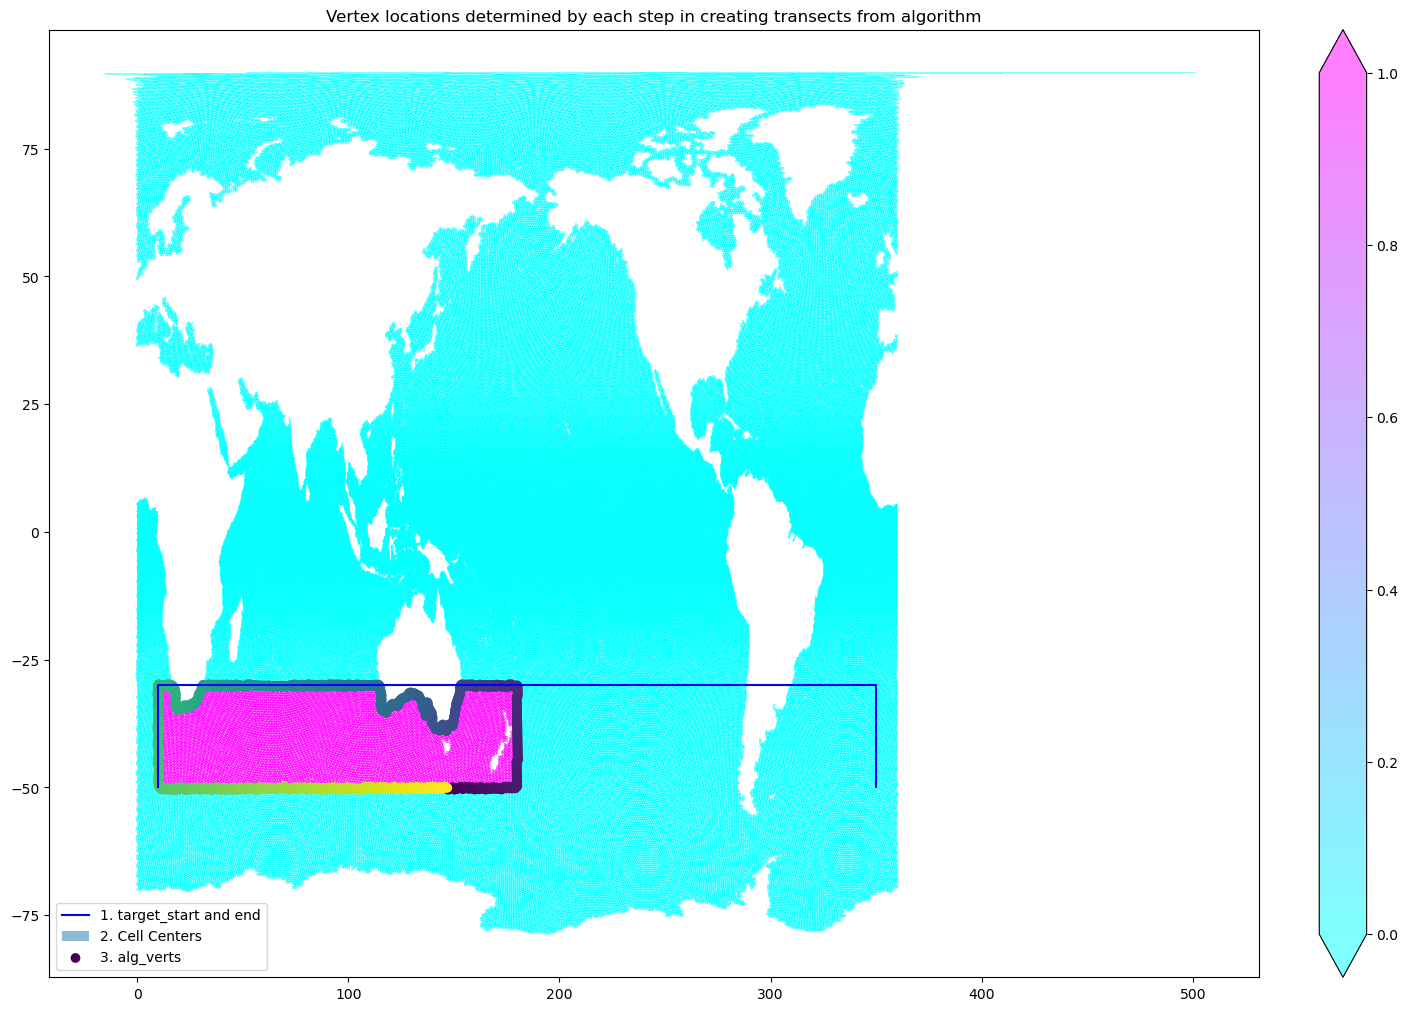

In [46]:
# plot this masked region
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

# LS the target start and end points when creating the algorithm
ax.plot(lons, lats, color='blue',label='1. target_start and end')

# plot the cellmask created from the cell centers in the mask (id'd with MPAS-tools)
# we don't need to worry about the mps.find_and_sort_transect_edges_and_vertices function because 
# the cell centers will always be inside the mask
# create cellmasks (which cells centers are included in the masked region)

cellmask = mask.regionCellMasks.isel(nRegions=0).astype(bool)
c = mosaic.polypcolor(ax,descriptor,
                  cellmask.astype(int),cmap='cool',alpha = 0.5,
                  antialiaseds=False, label = '2. Cell Centers')

fig.colorbar(c, extend='both')

# LS (lats and lons of vertices from transect)
# ax.scatter(test_verts_lons + 360,test_verts_lats, s=60,marker='^',color='orange',label='3. test_verts')


# plot using vertex lats and lons (removed vertices on cells not in the mask)
vertex_lons = ds.lonVertex.isel(nVertices = alg_vertices) * 180 / np.pi
vertex_lats = ds.latVertex.isel(nVertices = alg_vertices) * 180 / np.pi

# plot the vertices after removing where there are duplicates. 
# the colorbar shows the index of the lons and lats for each vertex 
# (since it is a gradient --> the vertex lats and lons are in order)
ax.scatter(vertex_lons,vertex_lats,c=np.arange(0,len(vertex_lons)),label='3. alg_verts')

# ax.set_ylim(-70,-25)
# ax.set_xlim(160,200)

ax.set_title('Vertex locations determined by each step in creating transects from algorithm')
ax.legend(loc='lower left')

#fig.suptitle('Grid variables from mask made from transect algorithm + MPAS-Tools')

In [47]:
vertex_lons.max()

<xarray.DataArray 'lonVertex' ()> Size: 8B
array(180.42824894)
Coordinates:
    simulationStartTime  |S64 64B ...